In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm import tqdm
import datetime
import proplot as plot
from netCDF4 import Dataset
from wrf import getvar
import celer
from scipy.ndimage import gaussian_filter
import gc
%matplotlib inline

sys.path.insert(1, '/work/08350/tg876493/stampede2/python_codes/2020_TC_CRF/dev/freddy0218/tools/')
import derive_var
import read_and_proc
import mlr

plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

In [2]:
#Function####################################################
import json,pickle
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values
def save_to_pickle(loc=None,var=None):
    with open(loc,"wb") as f:
        pickle.dump(var,f)
    return None

def forward_diff(arrayin=None,delta=None,axis=None,LT=1):
    result = []
    if axis==0:
        for i in range(0,arrayin.shape[axis]-LT):
            temp = (arrayin[i+LT,:]-arrayin[i,:])/(LT*delta)
            result.append(temp)
        return np.asarray(result)

def flatten(t):
    #https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
    return [item for sublist in t for item in sublist]
def standardize(t,formula='I'):
    if formula=='I':
        return (t-np.min(np.asarray(t)))/(np.max(np.asarray(t))-np.min(np.asarray(t)))
    elif formula=='II':
        return (t-np.mean(np.asarray(t)))/(np.std(np.asarray(t)))

In [4]:
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import MultiTaskLassoCV
from celer import MultiTaskLassoCV
from celer import Lasso
from sklearn.linear_model import ElasticNet
def produce_regscore(inPUT=None,outPUT=None,aux_inPUT=None,outtype='score',do_aux=False,
                     algorithm='linear',lassoparam=dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha=0.001):
    if algorithm=='linear':
        reg = LinearRegression().fit(inPUT, outPUT)
    elif algorithm=='lasso':
        #reg = MultiTaskLassoCV(**lassoparam).fit(inPUT,outPUT)
        reg = Lasso(simplelassoalpha).fit(inPUT,outPUT)
    elif algorithm=='multilasso':
        reg = MultiTaskLassoCV(**lassoparam).fit(inPUT,outPUT)
    if outtype=='score':
        if do_aux is False:
            return reg.score(inPUT, outPUT)
        elif do_aux is True:
            return reg.score(aux_inPUT,outPUT)
    elif outtype=='predict':
        return reg.predict(inPUT)
    elif outtype=='coeff':
        return reg.coef_
    
def delete_padding(inTS=None,outTS=None):
    output_nozero,input_nozero = [],[]
    for i in range(len(outTS[:,0])):
        temp = outTS[i,:]
        tempin = inTS[i,:]
        if temp.all()==0:
            continue
        else:
            output_nozero.append(temp)
            input_nozero.append(tempin)
    return input_nozero,output_nozero

def output_regscore(inTS=None,outTS=None,LTlist=None,algorithm='linear',aux_inTS=None,do_aux=False,simplelassoalpha=0.001):
    if do_aux is False:
        return [produce_regscore(delete_padding(inTS,outTS[i])[0],delete_padding(inTS,outTS[i])[1],None,'score',False,algorithm,\
                                 dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha) for i in range(len(outTS))]
    elif do_aux is True:
        return [produce_regscore(delete_padding(inTS,outTS[i])[0],delete_padding(inTS,outTS[i])[1],aux_inTS[:-int(LTlist[i])],'score',True,algorithm,\
                                 dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha) for i in range(len(outTS))]
    
def output_regscore_withmemory(inTS=None,outTS=None,LTlist=None,algorithm='linear',aux_inTS=None,do_aux=False,simplelassoalpha=0.001):
    if do_aux is False:
        output = []
        for i in (range(len(outTS))):
            inTSn,outTSn = delete_padding(inTS,outTS[i])[0],delete_padding(inTS,outTS[i])[1]
            inTRAIN = np.concatenate(((inTSn[int(LTlist[i]):]),(inTSn[0:-int(LTlist[i])])),axis=1)
            outTRAIN = outTSn[int(LTlist[i]):]
            output.append(produce_regscore(inTRAIN,outTRAIN,None,'score',False,algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha))
        return output
    elif do_aux is True:
        output = []
        for i in (range(len(outTS))):
            inTSn,outTSn = delete_padding(inTS,outTS[i])[0],delete_padding(inTS,outTS[i])[1]
            inTRAIN = np.concatenate(((inTSn[int(LTlist[i]):]),(inTSn[0:-int(LTlist[i])])),axis=1)
            outTRAIN = outTSn[int(LTlist[i])]
            auxin = np.concatenate(((aux_inTS[:-int(LTlist[i])][int(LTlist[i]):]),(aux_inTS[:-int(LTlist[i])][0:-int(LTlist[i])])),axis=1)
            output.append(produce_regscore(inTRAIN,outTRAIN,auxin,'score',True,algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha))
        return output        
    
def output_regcoeff(inTS=None,outTS=None,LTlist=None,algorithm='linear',memory='with',simplelassoalpha=0.001):
    if memory=='with':
        output = []
        for i in range(len(outTS)):
            inarray = np.concatenate(((inTS[:-int(LTlist[i])][int(LTlist[i]):]),(inTS[:-int(LTlist[i])][0:-int(LTlist[i])])),axis=1)
            outarray = outTS[i][int(LTlist[i]):-int(LTlist[i])]
            output.append(produce_regscore(inarray,outarray,'coeff',algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),0.01))
        return output
    elif memory=='without':
        return [produce_regscore(inTS[:-int(LTlist[i])],outTS[i][:-int(LTlist[i])],'coeff',algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha) for i in range(len(outTS))]
    
def output_regpredict(inTS=None,outTS=None,LTlist=None,algorithm='linear',memory='without',simplelassoalpha=0.001):
    if memory=='with':
        output = []
        for i in range(len(outTS)):
            inarray = np.concatenate(((inTS[:-int(LTlist[i])][int(LTlist[i]):]),(inTS[:-int(LTlist[i])][0:-int(LTlist[i])])),axis=1)
            outarray = outTS[i][int(LTlist[i]):-int(LTlist[i])]
            output.append(produce_regscore(inarray,outarray,None,'predict',False,algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),0.01))
        return output
    elif memory=='without':
        return [produce_regscore(delete_padding(inTS,outTS[i])[0],delete_padding(inTS,outTS[i])[1],None,'predict',False,algorithm,
                                 dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha) for i in range(len(outTS))]

#### Plot weights

In [9]:
path = './output/1010_nc/MLR_train/'
file2 = [path+'mlr_inputdictN_T6_norm',path+'mlr_outputN_T6_norm']
#file2_l = [path+'lasso/mlr_inputdictN_T5_norm_lasso',path+'lasso/mlr_outputN_T5_norm_lasso']

output,output_l = [],[]
for i in range(len(file2)):
    with open(file2[i],'rb') as f:
        output.append(pickle.load(f))
mlr_inputdict,mlr_output = output[0],output[1]
del output
gc.collect()

6117

In [11]:
LinearRegression().fit(mlr_inputdict['dtuvw'],mlr_output[11]).coef_.shape

(37, 49)

In [14]:
test = (LinearRegression().fit(mlr_inputdict['dtuvw'],mlr_output[11]).coef_-np.nanmean(LinearRegression().fit(mlr_inputdict['dtuvw'],mlr_output[11]).coef_))/np.nanstd(LinearRegression().fit(mlr_inputdict['dtuvw'],mlr_output[11]).coef_)

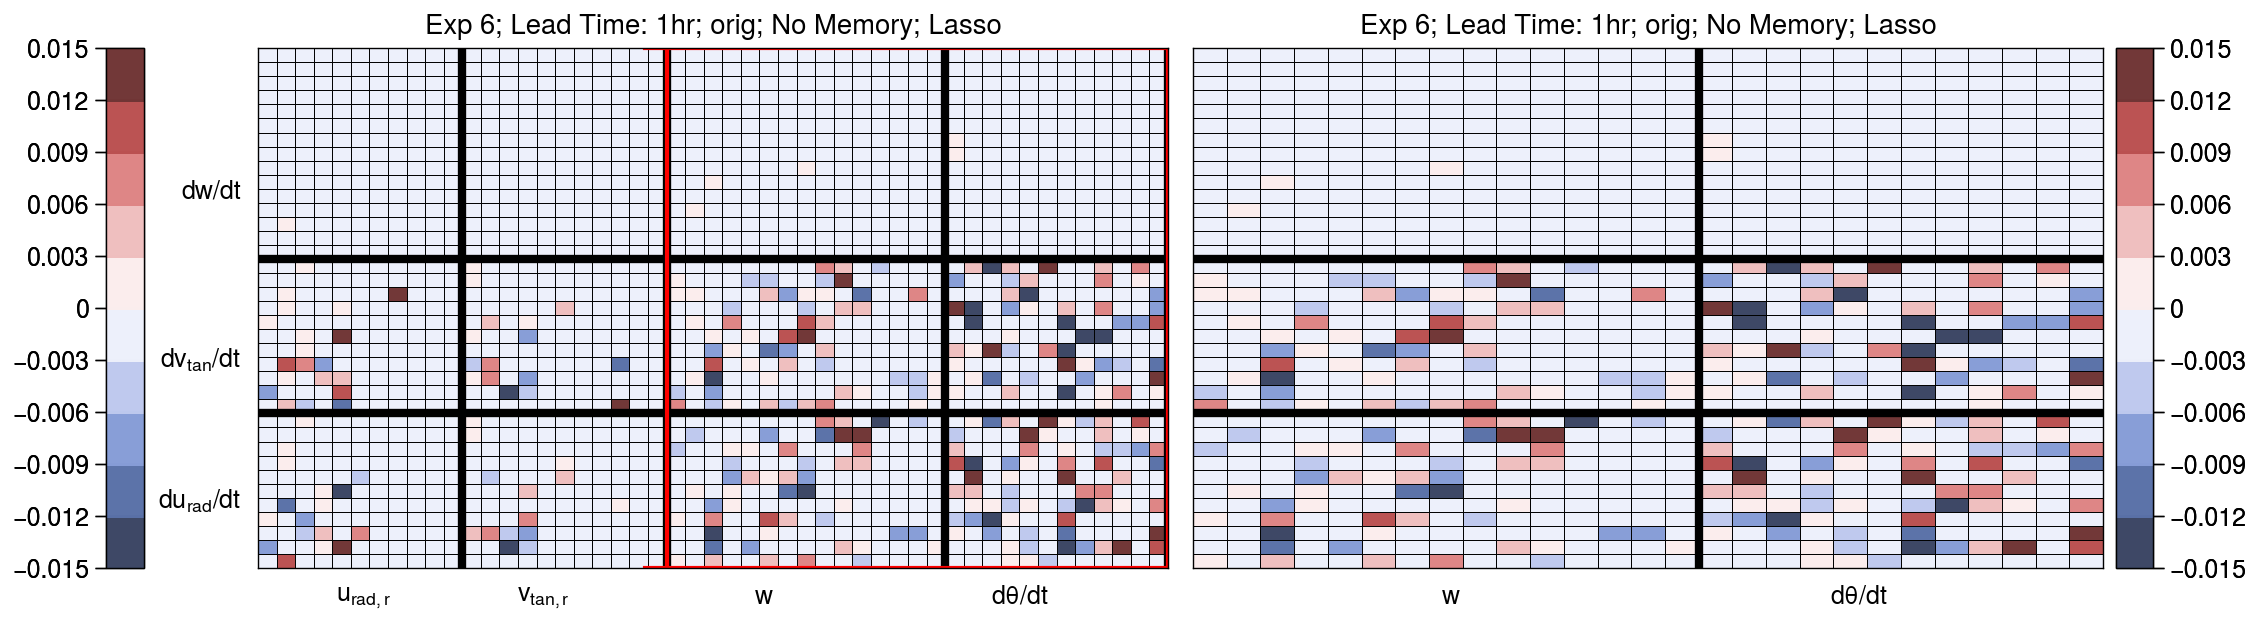

In [32]:
# nocomp = [9,9,13]
inx = 0
simplelassoalpha = 0.001
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=4.55,refaspect=1.751,share=False,sharey=True)
cout=axs[0].pcolormesh(Lasso(simplelassoalpha).fit(mlr_inputdict['dtuvw'],mlr_output[int(inx)]).coef_,cmap='div',edgecolors='k', linewidths=0.25,alpha=0.99, 
                       shading='auto',vmin=-0.015,vmax=0.015)#vmin=-0.015,vmax=0.015)
axs[0].colorbar(cout,loc='l')
axs[0].format(xticks=[5.15,14.85,26.75,40.5],xticklabels=['u$_{rad,r}$','v$_{tan,r}$','w',r'd$\theta$/dt'],yticks=[4.5,14.5,26.5],
              yticklabels=['du$_{rad}$/dt','dv$_{tan}$/dt','dw/dt'],title='Exp 6; Lead Time: '+(str(inx+1))+'hr; orig; No Memory; Lasso')
axs[0].tick_params(axis='y',which='both',left=False)
axs[0].tick_params(axis='x',which='both',bottom=False)
for i in [11-0.5,22-0.5,37-0.5,37-0.5+12]:
    axs[0].axvline(i,lw=3,color='k')
for i in [11-0.5,22-0.5]:
    axs[0].axhline(i,lw=3,color='k')
####################################################
# Square
#..................................................
for i in [22-0.5,37-0.5+12]:
    axs[0].axvline(i,lw=1.5,color='r')
for i in [0-0.5,36+0.5]:
    axs[0].axhline(i,xmin=0.425,xmax=1,lw=1.5,color='r')
####################################################

cout=axs[1].pcolormesh(Lasso(simplelassoalpha).fit(mlr_inputdict['dtuvw'],mlr_output[int(inx)]).coef_[:,22:],cmap='div',edgecolors='k', linewidths=0.25,alpha=0.99, shading='auto',vmin=-0.015,vmax=0.015)
axs[1].colorbar(cout,loc='r')
axs[1].format(xticks=[7.15,19.25],xticklabels=['w',r'd$\theta$/dt'],yticks=[4.5,12.5,22.5],
              yticklabels=['','',''],title='Exp 6; Lead Time: '+(str(inx+1))+'hr; orig; No Memory; Lasso')
axs[1].tick_params(axis='y',which='both',left=False)
axs[1].tick_params(axis='x',which='both',bottom=False)
#for i in [9-0.5,18-0.5,31-0.5,31-0.5+12]:
#    axs[0].axvline(i,lw=3,color='k')
for i in [15-0.5]:
    axs[1].axvline(i,lw=3,color='k')
for i in [11-0.5,22-0.5]:
    axs[1].axhline(i,lw=3,color='k')
plt.savefig('./proc_fig/1212/uvwt_exp6lt'+(str(inx+1))+'_nm_coeff_lasso.png',dpi=400)
plt.show()